# Pneumonia detection in chest X-ray images

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Typically symptoms include some combination of cough, chest pain, fever, and trouble breathing [1].
Pneumonia affects approximately 450 million people globally (7% of the population) and results in about 4 million deaths per year [2]. To diagnose this disease, chest X-ray images remain the best diagnosis tool.

![](example-pneumonia.jpeg) *Chest X-ray image of a patient with Pneumonia*

In this tutorial, we use a model trained to classify patients with pneumonia over healthy cases based on their chest X-ray images. The topology used is the DenseNet 121, this architecture has shown to be very efficient at this problem, it was the first work to claim classification rate better than practicing radiologists. The dataset used for training is from the "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification" [3] with a CC BY 4.0 license.
The trained model is provided as a frozen Tensorflow model (.pb).

![](densenet.jpg) *DenseNet Architecture, Copyright (c) 2016, Zhuang Liu. All rights reserved.*


**In this tutorial, we perform inference on this model using the OpenVINO(TM) toolkit on the validation dataset on multiple hardware targets such as different Intel CPUS, Neural Compute Stick, the Intel® Arria® 10 FPGA, etc...
We will also visualize what the network has learned using the technique of Class Activation Maps.**

[1] Ashby B, Turkington C (2007). The encyclopedia of infectious diseases (3rd ed.). New York: Facts on File. p. 242. ISBN 978-0-8160-6397-0. 

[2] Ruuskanen O, Lahti E, Jennings LC, Murdoch DR (April 2011). "Viral pneumonia". Lancet. 377 (9773): 1264–75. 

[3] Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification, http://dx.doi.org/10.17632/rscbjbr9sj.2#file-41d542e7-7f91-47f6-9ff2-dd8e5a5a7861

## 1. Model Optimizer

First, we need to convert the model to OpenVINO Intermediate Representation through the Model Optimizer. The MO script is *mo_tf.py*, which takes as input:  
-m: path to the input model (.pb)  
--input_shape: dimension of the input tensor (optional for most of the models)
--data_type: data type of the IR model (FP32 for CPU, FP16 for GPU, Movidius and FPGA)
-o : path where to save the IR

The second argument is not necessary for  models with a defined input shape. However, Tensorflow models often have dynamic input shapes (often the batch will be set as -1), which is not supported by OpenVINO.

First, we convert the model to a FP32 IR format.

In [2]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py -m model.pb --input_shape=[1,224,224,3] --data_type FP32 -o models/FP32 --mean_values [123.75,116.28,103.58] --scale_values [58.395,57.12,57.375] 


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u23298/Reference-samples/iot-devcloud/python/pneumonia-classification-python/model.pb
	- Path for generated IR: 	/home/u23298/Reference-samples/iot-devcloud/python/pneumonia-classification-python/models/FP32
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	[123.75,116.28,103.58]
	- Scale values: 	[58.395,57.12,57.375]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custo

We also convert to FP16.

In [73]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py -m model.pb --input_shape=[1,224,224,3] --data_type FP16 -o models/FP16/ --mean_values [123.75,116.28,103.58] --scale_values [58.395,57.12,57.375]


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u23298/Reference-samples/iot-devcloud/python/pneumonia-classification-python/model.pb
	- Path for generated IR: 	/home/u23298/Reference-samples/iot-devcloud/python/pneumonia-classification-python/models/FP16/
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	[123.75,116.28,103.58]
	- Scale values: 	[58.395,57.12,57.375]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow cust

Let's visualize the result Intermediate Representation (.xml). You can observe the different layers with informations such as name, operation type, precision, input shape and output shape. 

In [7]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(open('models/FP16/model.xml'), 'xml')
print(bs.prettify()) 

<?xml version="1.0" encoding="utf-8"?>
<net batch="1" name="model" version="5">
 <layers>
  <layer id="0" name="input_1_1" precision="FP16" type="Input">
   <output>
    <port id="0">
     <dim>
      1
     </dim>
     <dim>
      3
     </dim>
     <dim>
      224
     </dim>
     <dim>
      224
     </dim>
    </port>
   </output>
  </layer>
  <layer id="1" name="Mul_/Fused_Mul_/FusedScaleShift_" precision="FP16" type="ScaleShift">
   <input>
    <port id="0">
     <dim>
      1
     </dim>
     <dim>
      3
     </dim>
     <dim>
      224
     </dim>
     <dim>
      224
     </dim>
    </port>
   </input>
   <output>
    <port id="3">
     <dim>
      1
     </dim>
     <dim>
      3
     </dim>
     <dim>
      224
     </dim>
     <dim>
      224
     </dim>
    </port>
   </output>
   <blobs>
    <weights offset="0" size="6"/>
    <biases offset="6" size="6"/>
   </blobs>
  </layer>
  <layer id="2" name="conv1/conv_1/convolution" precision="FP16" type="Convolution">
   <data

At this point, we are able to perform inference with OpenVINO. 

## 2. Inference with OpenVINO on the server

In this part, we will perform inference on the server (Xeon SkyLake) in order to showcase the Python API of the OpenVINO inference engine. 
Then, we will showcase how to use our API to compute the Class Activation Maps. 
In Section 3, we will perform inference on other hardware target devices.

First, we import several useful Python packages. 

In [4]:
from __future__ import print_function
import sys
import os,glob
import numpy as np
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

We set several variables such as path to the IR model, the target device and path to the images. 

In [5]:
model_xml = "models/FP32/model.xml"
device="CPU"
files_pneumonia=glob.glob(os.getcwd()+'/validation_images/PNEUMONIA/*.jpeg')
files_healthy=glob.glob(os.getcwd()+'/validation_images/NORMAL/*.jpeg')
colormap='viridis'

First, we define an image reading function that uses OpenCV for image loading, resize it to the network input size, and reshape the image numpy array into CHW (Channels, Height, Width).

In [6]:
from utils import load_img, img_to_array, resize_image

def read_image(path):
    image_original = load_img(path, color_mode="rgb")
    img= resize_image(image_original, target_size=(224, 224))
    x = img_to_array(img, data_format='channels_first')
    return [x,image_original]


### 2.1 Classification

First, we want to perform the classification of the pneumonia cases over the healthy patients.  

Pneumomina cases


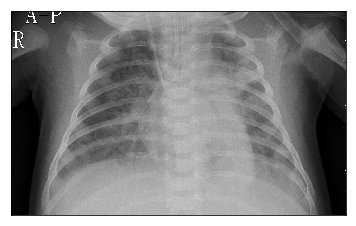

Probability of having disease= 0.99469876 (ground truth: pneumonia case), performed in 51.198720932006836 ms


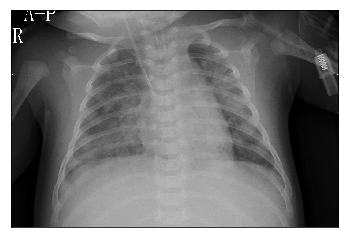

Probability of having disease= 0.6742022 (ground truth: pneumonia case), performed in 95.01504898071289 ms


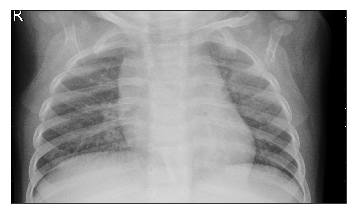

Probability of having disease= 0.6288929 (ground truth: pneumonia case), performed in 89.3702507019043 ms


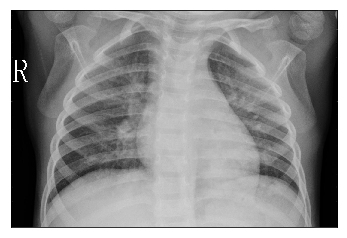

Probability of having disease= 0.46769607 (ground truth: pneumonia case), performed in 67.11864471435547 ms


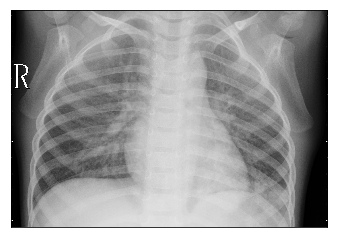

Probability of having disease= 0.66353136 (ground truth: pneumonia case), performed in 81.26592636108398 ms


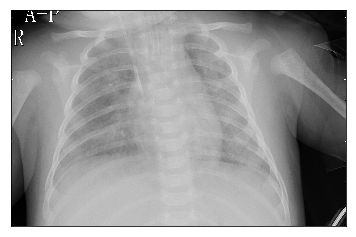

Probability of having disease= 0.97624254 (ground truth: pneumonia case), performed in 91.58587455749512 ms


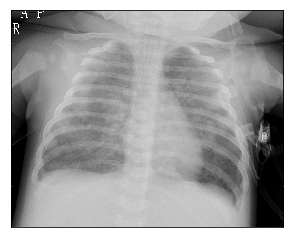

Probability of having disease= 0.8660525 (ground truth: pneumonia case), performed in 76.54333114624023 ms


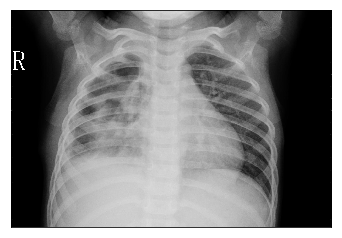

Probability of having disease= 0.93034065 (ground truth: pneumonia case), performed in 52.6735782623291 ms


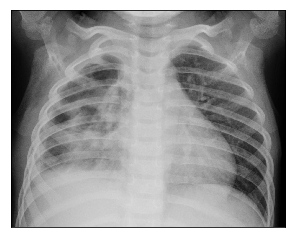

Probability of having disease= 0.9385493 (ground truth: pneumonia case), performed in 83.77480506896973 ms
Healthy cases


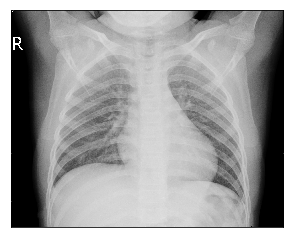

Probability of having disease= 0.008746749 (ground truth: healthy case), performed in 48.78640174865723 ms


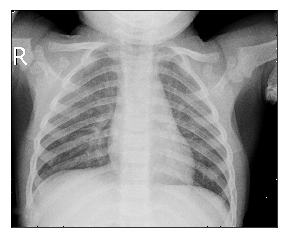

Probability of having disease= 0.0020681622 (ground truth: healthy case), performed in 79.62751388549805 ms


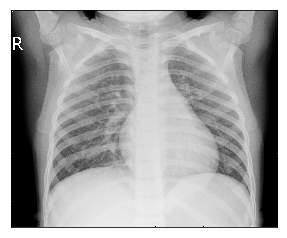

Probability of having disease= 0.057020027 (ground truth: healthy case), performed in 72.34692573547363 ms


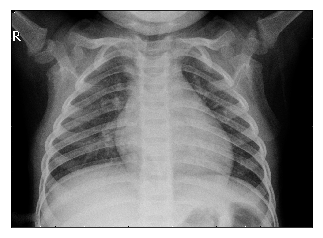

Probability of having disease= 0.0091878055 (ground truth: healthy case), performed in 75.36721229553223 ms


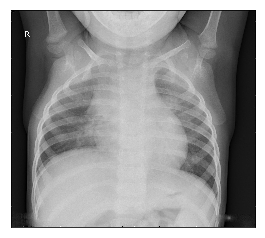

Probability of having disease= 0.03582874 (ground truth: healthy case), performed in 62.1488094329834 ms


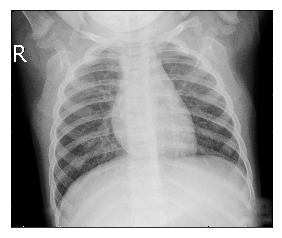

Probability of having disease= 0.0064245253 (ground truth: healthy case), performed in 80.40833473205566 ms


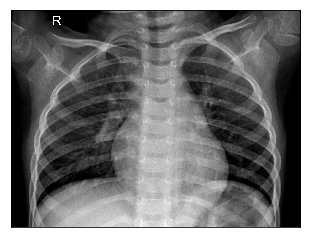

Probability of having disease= 0.06678789 (ground truth: healthy case), performed in 50.77862739562988 ms


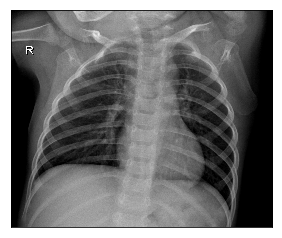

Probability of having disease= 0.006728867 (ground truth: healthy case), performed in 47.76930809020996 ms


In [7]:
model_bin = os.path.splitext(model_xml)[0] + ".bin"

# Plugin initialization for specified device and load extensions library if specified
plugin = IEPlugin(device=device)

# Read IR
net = IENetwork(model=model_xml, weights=model_bin)

assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"

input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))

net.batch_size = 1

exec_net = plugin.load(network=net)

n,c,h,w=net.inputs[input_blob].shape
case=0

print("Pneumomina cases")
for file in sorted(files_pneumonia):
    [image1,image]= read_image(file)
    t0 = time()
    res = exec_net.infer(inputs={input_blob: image1})
    infer_time=(time() - t0) * 1000
    res_pb = res[out_blob]
    probs=res_pb[0][0]
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print("Probability of having disease= "+str(probs)+" (ground truth: pneumonia case), performed in " + str(infer_time) +" ms" )
        
print("Healthy cases")        
for file in sorted(files_healthy):
    [image1,image]= read_image(file)
    t0 = time()
    res = exec_net.infer(inputs={input_blob: image1})
    infer_time=(time() - t0) * 1000
    res_pb = res[out_blob]
    probs=res_pb[0][0]
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print("Probability of having disease= "+str(probs)+" (ground truth: healthy case), performed in " + str(infer_time) +" ms")


    

### 2.2 Visualize what the model has learned

Class activation maps (CAM) [1] are a simple technique to visualize the regions that are relevant to a Convolutional Neural Network to identify a specific class in the image. 
The CAM $M(x,y)$ is calculated from the N feature maps $f_i(x,y)$ from the last convolutional layer. We perform the weighted sum of those feature maps based on the weigths of the fully connected layer $w_i$ , which represents how important are those feaure maps for the classification output. 

$ M(x,y)=\sum_{i=0}^N w_i f_i(x,y) $

[1] Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

In order to calculate Class Activation Maps in OpenVINO, we need to access the output feature maps of the last convolution layer and the weights of the fully connected layer. 
By default, only the output layer is the output (obviously). Therefore, in order to get the feature maps, we need to add the last convolution as an additional output. 
This is simply done by using the function *add_outputs("layer_name")* on the network before loading it to the plugin. 
In order to obtain the layers name, we recommend Netron, which allows to visualize graphically the model. 

In order to get the feature maps, inference must be performed first. This is why our function to calculate the Class Action Maps requires the inference output (which includes the feature maps since we added an additional output previously).
We access the FC layer weights using the call *net.layers.get("name_of_fully_connected_layer").weights["weights"]*

Then, we perform the weighted sum of the weights with the feature maps.

In [8]:
def visualize_class_activation_map_openvino(res, bn, fc, net):
    res_bn = res[bn]
    weights_fc=net.layers.get(fc).weights["weights"]
    conv_outputs=res_bn[0,:,:,:]
    cam = np.zeros(dtype=np.float32, shape=(conv_outputs.shape[1:]))
    for i, w in enumerate(weights_fc):
        cam += w * conv_outputs[i, :, :]
    return cam

We have now defined the generic function in order to obtain the Class Activation Maps, let's use it now for our example. 

We define first the name of the last convolutional layer from which we need to extract the feature maps. In our example, the layer is called: **Mul1_15719/Fused_Mul_/FusedScaleShift_**.
We also set the name of the Fully-Connected layer, in our case **predictions/MatMul**

Loading model to the plugin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.99469876] (ground truth: pneumonia case), performed in 47.40643501281738 ms
Time for CAM: 6.291866302490234 ms


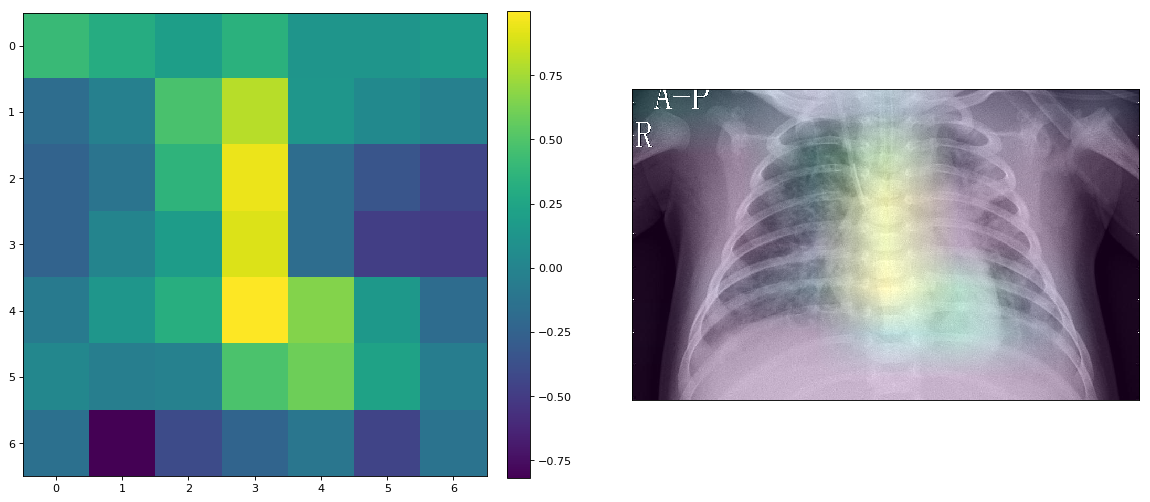

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.6742022] (ground truth: pneumonia case), performed in 46.53000831604004 ms
Time for CAM: 6.559848785400391 ms


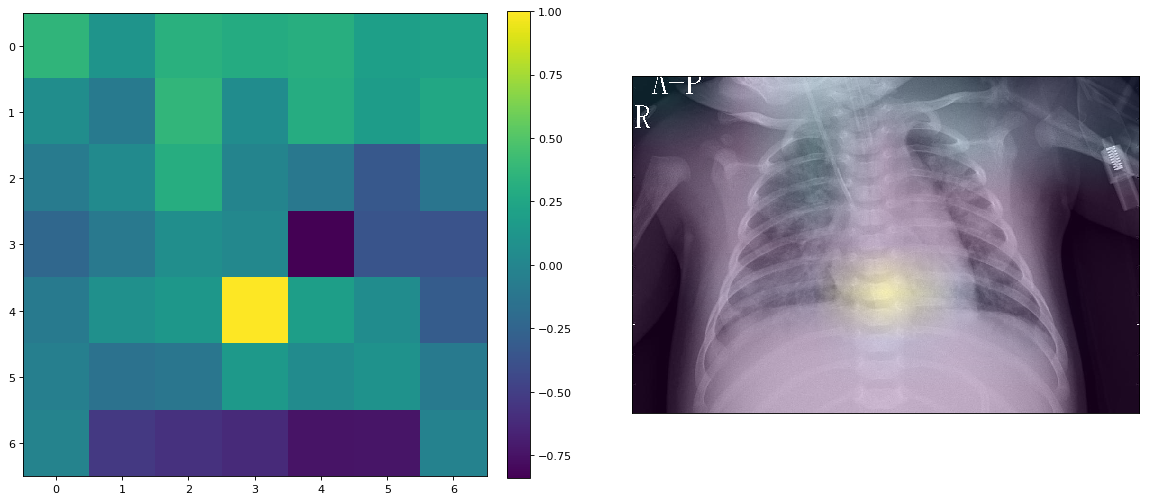

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.6288929] (ground truth: pneumonia case), performed in 51.50794982910156 ms
Time for CAM: 6.636619567871094 ms


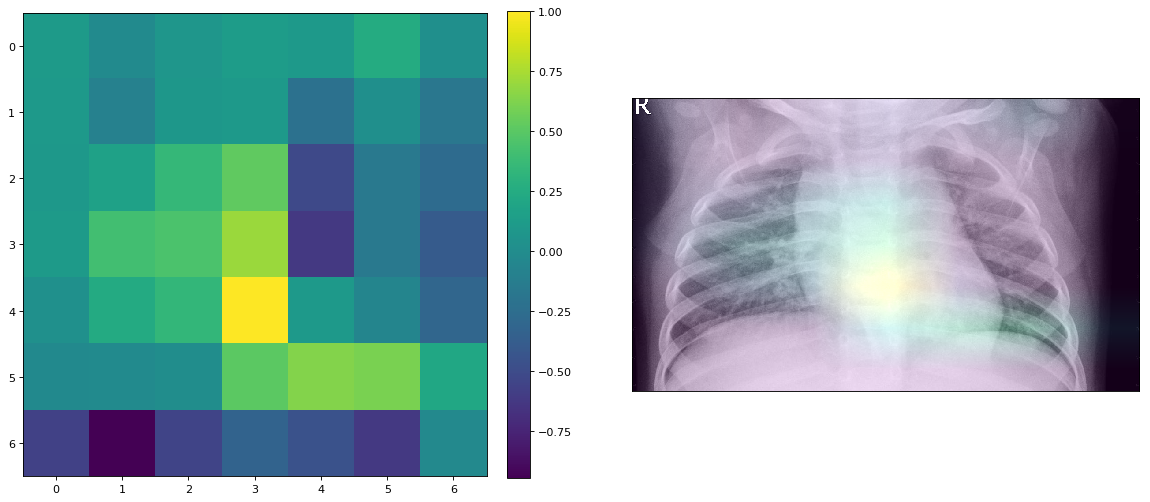

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.46769607] (ground truth: pneumonia case), performed in 49.90506172180176 ms
Time for CAM: 6.09278678894043 ms


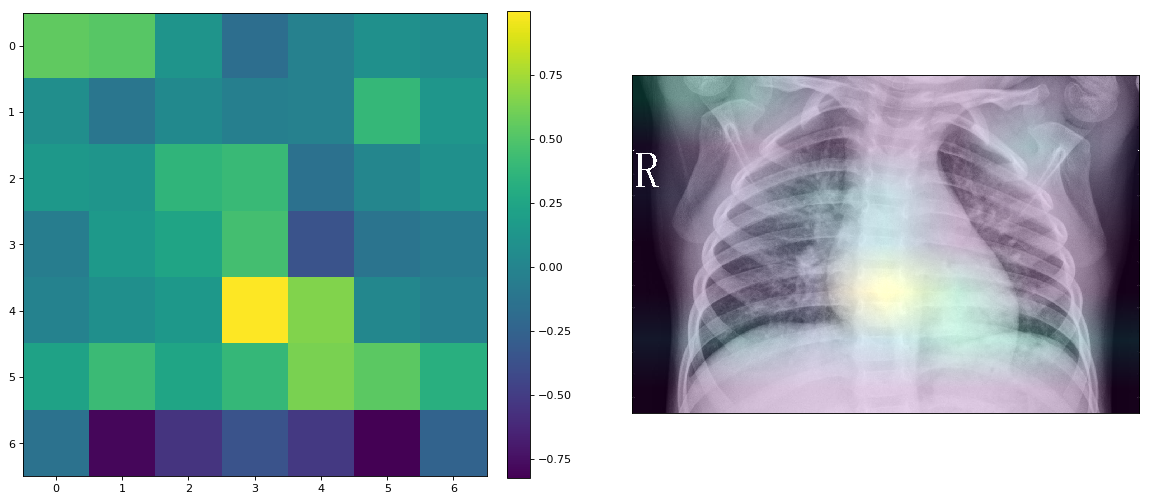

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.66353136] (ground truth: pneumonia case), performed in 51.245689392089844 ms
Time for CAM: 6.0138702392578125 ms


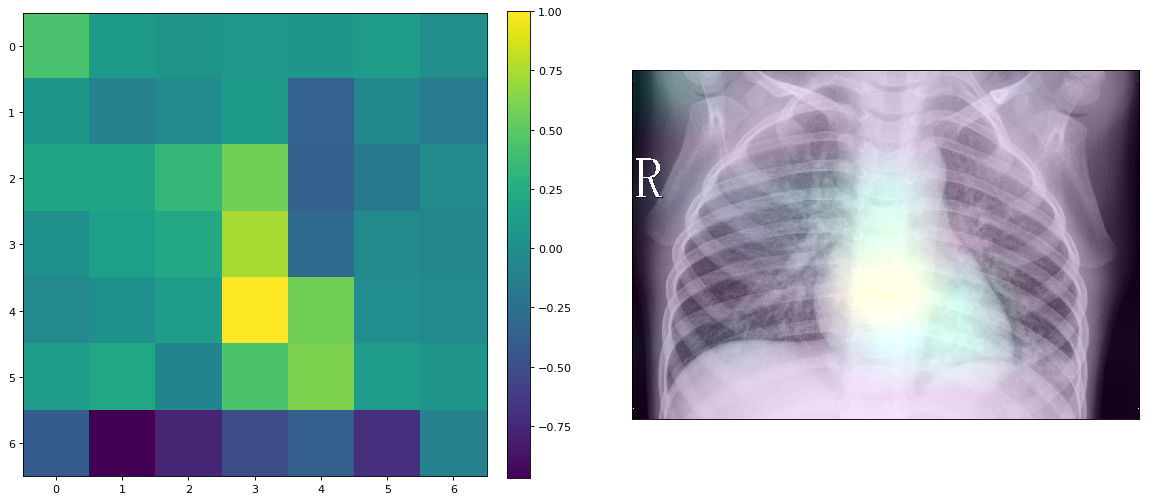

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.97624254] (ground truth: pneumonia case), performed in 53.197622299194336 ms
Time for CAM: 6.441831588745117 ms


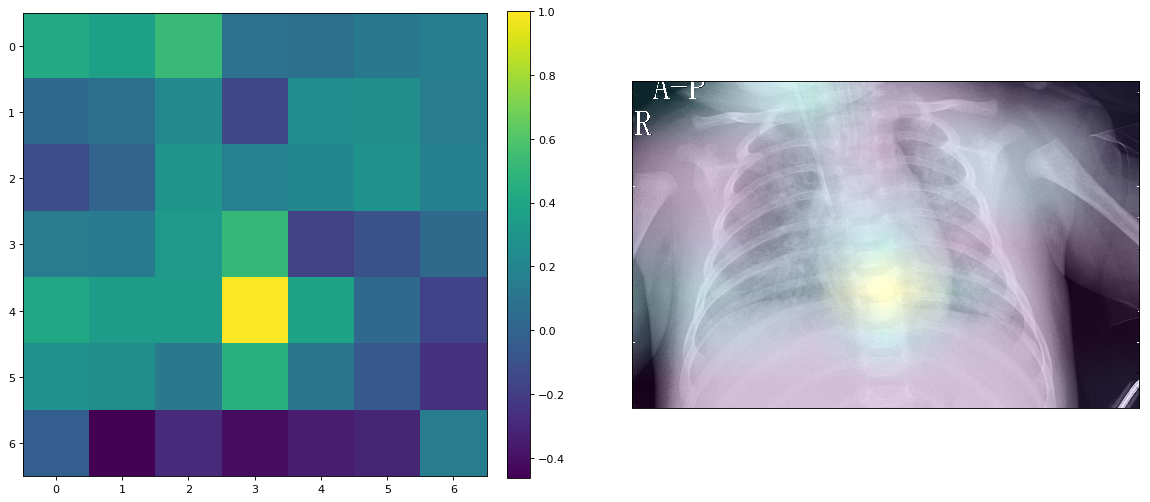

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.8660525] (ground truth: pneumonia case), performed in 50.660133361816406 ms
Time for CAM: 6.7501068115234375 ms


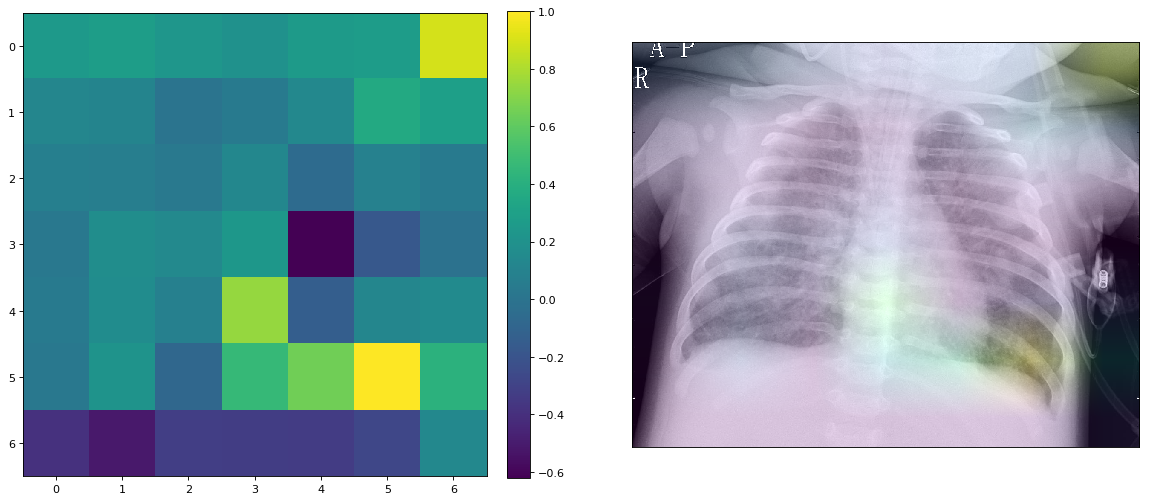

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.93034065] (ground truth: pneumonia case), performed in 60.41073799133301 ms
Time for CAM: 7.0209503173828125 ms


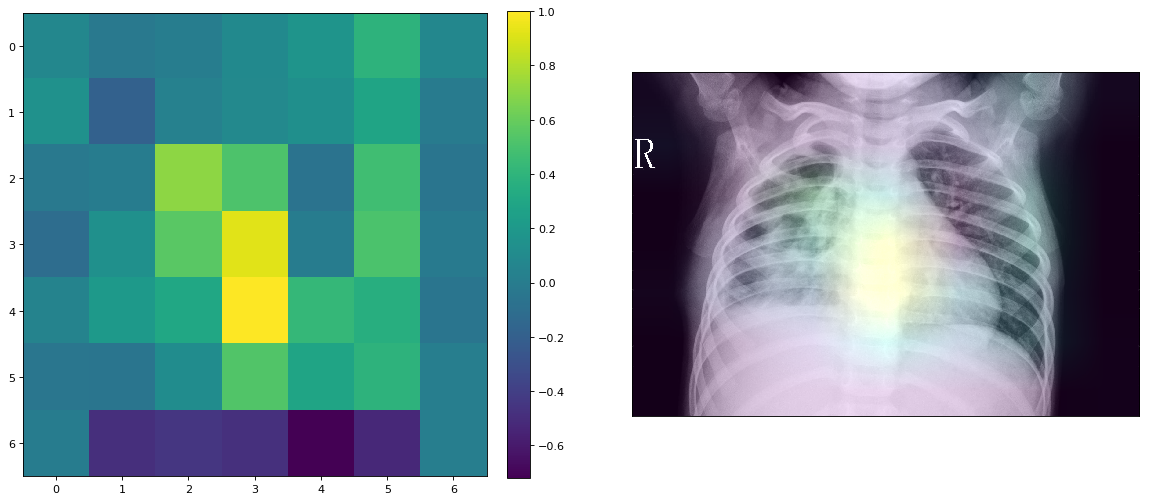

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of having disease= [0.9385493] (ground truth: pneumonia case), performed in 49.950361251831055 ms
Time for CAM: 7.016181945800781 ms


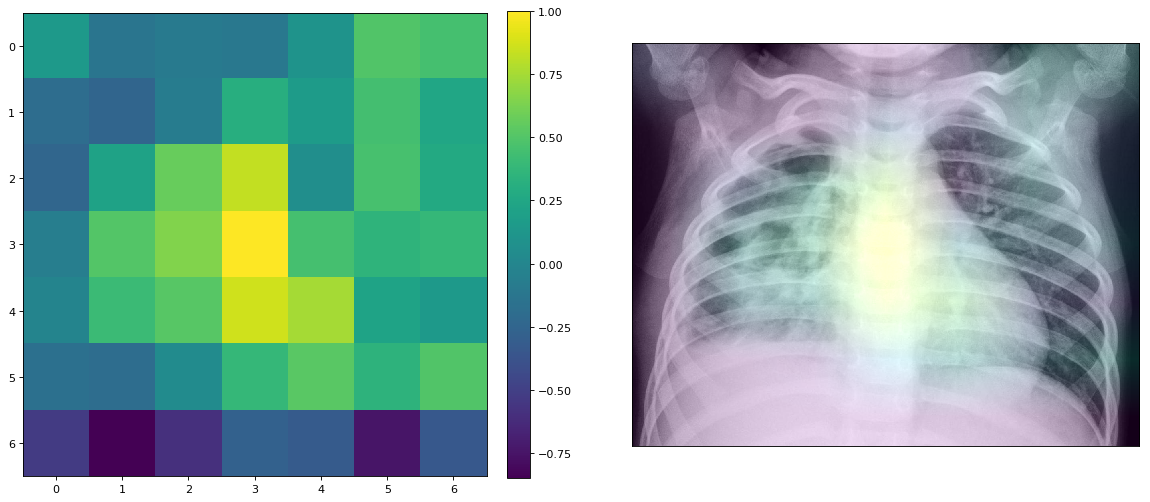

In [10]:
bn="Mul1_15719/Fused_Mul_/FusedScaleShift_"

# add the last convolutional layer as output 
net.add_outputs(bn)
fc="predictions_1/MatMul"

# name of the inputs and outputs
input_blob = next(iter(net.inputs))
out_blob = "predictions_1/Sigmoid"

#set the batch size
net.batch_size = 1

# Loading model to the plugin
print("Loading model to the plugin")
exec_net = plugin.load(network=net)

#obtain the shape of the input
n,c,h,w=net.inputs[input_blob].shape

#iterate over the pneumonia cases
for file in sorted(files_pneumonia):
    #read the image
    [image1,image]= read_image(file)
    # Start inference
    t0 = time()
    res = exec_net.infer(inputs={input_blob: image1})
    infer_time=(time() - t0) * 1000
    
    # Process the classification output
    res_pb = res[out_blob]
    probs=res_pb[0]
    print("Probability of having disease= "+str(probs)+" (ground truth: pneumonia case), performed in " + str(infer_time) +" ms")
    
    # Class Activation Map    
    t0 = time()
    cam=visualize_class_activation_map_openvino(res, bn, fc , net)
    cam_time=(time() - t0) * 1000
    print("Time for CAM: {} ms".format(cam_time))
    
    
    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    # Visualize the CAM heatmap
    cam /= np.max(cam)
    fig.add_subplot(1, 2, 1)
    plt.imshow(cam, cmap=colormap)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    # Visualize the CAM overlaid over the X-ray image 
    colormap_val=cm.get_cmap(colormap)  
    imss=np.uint8(colormap_val(cam)*255)
    im = Image.fromarray(imss)
    width, height = image.size
    cam1=resize_image(im, (height,width))
    heatmap = np.asarray(cam1)
    img1 = heatmap [:,:,:3] * 0.3 + image
    fig.add_subplot(1, 2, 2)
    
    
    plt.imshow(np.uint16(img1))
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    

## 3. Inference on the edge


All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel Xeon Scalable processor, where the Notebook is allocated a single core. 
We will run the workload on other edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook. It performs the classification using the script classification_pneumonia.py which is very similar to the Python code that we developed in Section 2. 

In [108]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

In [86]:
%%writefile classification_pneumonia_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
# Traffic detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
if [ "$2" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi

# Running the traffic detection code
SAMPLEPATH=${PBS_O_WORKDIR}
echo ${1}
python3 classification_pneumonia.py  -m models/$FP_MODEL/model.xml  \
                                           -i /validation_images/PNEUMONIA/*.jpeg \
                                           -o $OUTPUT_FILE \
                                           -d $DEVICE
                                

Overwriting classification_pneumonia_job.sh


### 3.1 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit ocr_job to 5 different types of edge compute nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [classification_pneumonia_job.sh](classification_pneumonia_job.sh) takes in 3 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU,GPU,MYRIAD)
3. the floating precision to use for inference

The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [87]:
!pbsnodes | grep compnode | sort | uniq -c

     35      properties = idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,1gbe
     15      properties = idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     18      properties = idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     23      properties = idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
     10      properties = idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     16      properties = idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     15      properties = idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1      properties = idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1

Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 3.2 Job queue submission

The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells).


#### Submitting to an edge compute node with an Intel Core CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [153]:
#Submit job to the queue
job_id_core = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core CPU FP32" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if not job_id_core:
    print("Error in job submission.")

Submitting a job to an edge compute node with an Intel Core CPU...
21843.c003


#### Submitting to an edge compute node with Intel Xeon CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [154]:
#Submit job to the queue
job_id_xeon = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:e3-1268l-v5 -F "results/xeon CPU FP32" -N obj_det_xeon
print(job_id_xeon[0]) 
#Progress indicators
if not job_id_xeon:
    print("Error in job submission.")

Submitting a job to an edge compute node with an Intel Xeon CPU...
21844.c003


#### Submitting to an edge compute node with Intel Core CPU and using the onboard Intel GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [155]:
#Submit job to the queue
job_id_gpu = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "results/gpu GPU FP16" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if not job_id_gpu:
    print("Error in job submission.")

21845.c003


#### Submitting to an edge compute node with  IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [156]:
#Submit job to the queue
job_id_fpga = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "results/fpga HETERO:FPGA,CPU FP16" -N obj_det_fpga
print(job_id_fpga[0]) 
#Progress indicators
if not job_id_fpga:
    print("Error in job submission.")

21846.c003


#### Submitting to an edge compute node with Intel NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [157]:
#Submit job to the queue
job_id_myriadx = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "results/myriadx MYRIAD FP16 " -N obj_det_myriadx
print(job_id_myriadx[0]) 
#Progress indicators
if not job_id_myriadx:
    print("Error in job submission.")


21847.c003


#### Submitting to an edge compute node with  IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [158]:
#Submit job to the queue
job_id_hddl = !qsub classification_pneumonia_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-v100-mx8 -F "results/hddl HDDL FP16" -N obj_det_hddl
print(job_id_hddl[0]) 
#Progress indicators
if not job_id_hddl:
    print("Error in job submission.")

21848.c003


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [159]:
#Submit job to the queue
job_id_up2 = !qsub classification_pneumonia_job.sh -l nodes=1:up-squared -F "results/up2 GPU FP16" -N obj_det_up2
print(job_id_up2[0]) 
#Progress indicators
if not job_id_up2:
    print("Error in job submission.")

21849.c003


### 3.3 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [53]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs complete before proceeding to the next step.

### 3.4 View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`obj_det_{type}.o{JobID}`

`obj_det_{type}.e{JobID}`

(here, obj_det_{type} corresponds to the `-N` option of qsub).

We also saved the probability output and inference time for each input image in the folder `results/` for each architecture. 
We observe the results below.



#### Result on the Intel Core CPU 

In [160]:
result_file="results/core/result"+job_id_core[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9946988
 Inference performed in 24.6ms 
Pneumonia probability: 0.9303405
 Inference performed in 24.6ms 
Pneumonia probability: 0.9385493
 Inference performed in 20.5ms 
Pneumonia probability: 0.97624254
 Inference performed in 20.5ms 
Pneumonia probability: 0.66353095
 Inference performed in 20.5ms 
Pneumonia probability: 0.628893
 Inference performed in 20.5ms 
Pneumonia probability: 0.467696
 Inference performed in 24.3ms 
Pneumonia probability: 0.86605257
 Inference performed in 20.5ms 
Pneumonia probability: 0.674203
 Inference performed in 23.1ms 



#### Result on the Intel Xeon CPU

In [161]:
result_file="results/xeon/result"+job_id_xeon[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9946988
 Inference performed in 23.0ms 
Pneumonia probability: 0.9303405
 Inference performed in 19.6ms 
Pneumonia probability: 0.9385493
 Inference performed in 19.6ms 
Pneumonia probability: 0.97624254
 Inference performed in 23.6ms 
Pneumonia probability: 0.66353095
 Inference performed in 19.8ms 
Pneumonia probability: 0.628893
 Inference performed in 20.7ms 
Pneumonia probability: 0.467696
 Inference performed in 20.6ms 
Pneumonia probability: 0.86605257
 Inference performed in 20.2ms 
Pneumonia probability: 0.674203
 Inference performed in 24.2ms 



#### Result on the Intel Integrated GPU

In [162]:
result_file="results/gpu/result"+job_id_gpu[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9941406
 Inference performed in 33.1ms 
Pneumonia probability: 0.9301758
 Inference performed in 32.9ms 
Pneumonia probability: 0.93847656
 Inference performed in 32.9ms 
Pneumonia probability: 0.9760742
 Inference performed in 32.8ms 
Pneumonia probability: 0.6665039
 Inference performed in 32.8ms 
Pneumonia probability: 0.6328125
 Inference performed in 32.9ms 
Pneumonia probability: 0.46875
 Inference performed in 32.8ms 
Pneumonia probability: 0.8676758
 Inference performed in 32.9ms 
Pneumonia probability: 0.6748047
 Inference performed in 32.9ms 



#### Result on the IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)

In [163]:
result_file="results/fpga/result"+job_id_fpga[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.98593634
 Inference performed in 11.3ms 
Pneumonia probability: 0.83973396
 Inference performed in 9.8ms 
Pneumonia probability: 0.8175745
 Inference performed in 9.9ms 
Pneumonia probability: 0.8596637
 Inference performed in 10.5ms 
Pneumonia probability: 0.3174263
 Inference performed in 10.1ms 
Pneumonia probability: 0.26894146
 Inference performed in 10.1ms 
Pneumonia probability: 0.14033626
 Inference performed in 9.0ms 
Pneumonia probability: 0.41300356
 Inference performed in 10.1ms 
Pneumonia probability: 0.16026604
 Inference performed in 10.4ms 



#### Result on the Intel NCS2

In [164]:
result_file="results/myriadx/result"+job_id_myriadx[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9970703
 Inference performed in 52.1ms 
Pneumonia probability: 0.91503906
 Inference performed in 51.9ms 
Pneumonia probability: 0.9482422
 Inference performed in 51.9ms 
Pneumonia probability: 0.9790039
 Inference performed in 52.3ms 
Pneumonia probability: 0.74902344
 Inference performed in 51.9ms 
Pneumonia probability: 0.69677734
 Inference performed in 51.7ms 
Pneumonia probability: 0.46289062
 Inference performed in 51.7ms 
Pneumonia probability: 0.84472656
 Inference performed in 52.0ms 
Pneumonia probability: 0.82714844
 Inference performed in 51.8ms 



#### Result on the IEI Mustang-V100-MX8

In [165]:
result_file="results/hddl/result"+job_id_hddl[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9970703
 Inference performed in 56.3ms 
Pneumonia probability: 0.91503906
 Inference performed in 54.5ms 
Pneumonia probability: 0.9482422
 Inference performed in 56.2ms 
Pneumonia probability: 0.9790039
 Inference performed in 54.8ms 
Pneumonia probability: 0.74902344
 Inference performed in 56.3ms 
Pneumonia probability: 0.69677734
 Inference performed in 54.8ms 
Pneumonia probability: 0.46289062
 Inference performed in 55.9ms 
Pneumonia probability: 0.84472656
 Inference performed in 54.3ms 
Pneumonia probability: 0.82714844
 Inference performed in 56.4ms 



#### Result on the UP2

In [168]:
result_file="results/up2/result"+job_id_up2[0]+".txt"
file_ready= os.path.isfile(result_file)
if file_ready:
    f=open(result_file)
    print(f.read())
else: 
    print("The results are not ready yet, please retry")

Pneumonia probability: 0.9941406
 Inference performed in 68.1ms 
Pneumonia probability: 0.9301758
 Inference performed in 67.0ms 
Pneumonia probability: 0.93847656
 Inference performed in 67.7ms 
Pneumonia probability: 0.9760742
 Inference performed in 67.4ms 
Pneumonia probability: 0.6665039
 Inference performed in 68.8ms 
Pneumonia probability: 0.6328125
 Inference performed in 68.7ms 
Pneumonia probability: 0.46875
 Inference performed in 67.0ms 
Pneumonia probability: 0.8676758
 Inference performed in 68.1ms 
Pneumonia probability: 0.6748047
 Inference performed in 67.0ms 



### 3.5 Assess Performance

The total average time of each inference task is recorded in `results/{ARCH}/statsjob_id.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

[('results/core/stats21843.c003.txt', 'Intel Core\ni5-6500TE\nCPU'), ('results/xeon/stats21844.c003.txt', 'Intel Xeon\nE3-1268L v5\nCPU'), ('results/gpu/stats21845.c003.txt', ' Intel Core\ni5-6500TE\nGPU'), ('results/fpga/stats21846.c003.txt', ' IEI Mustang\nF100-A10\nFPGA'), ('results/myriadx/stats21847.c003.txt', 'Intel\nNCS2'), ('results/hddl/stats21848.c003.txt', ' IEI Mustang\nV100-MX8\nVPU'), ('results/up2/stats21849.c003.txt', 'Intel Atom\nx7-E3950\nUP2/GPU')]


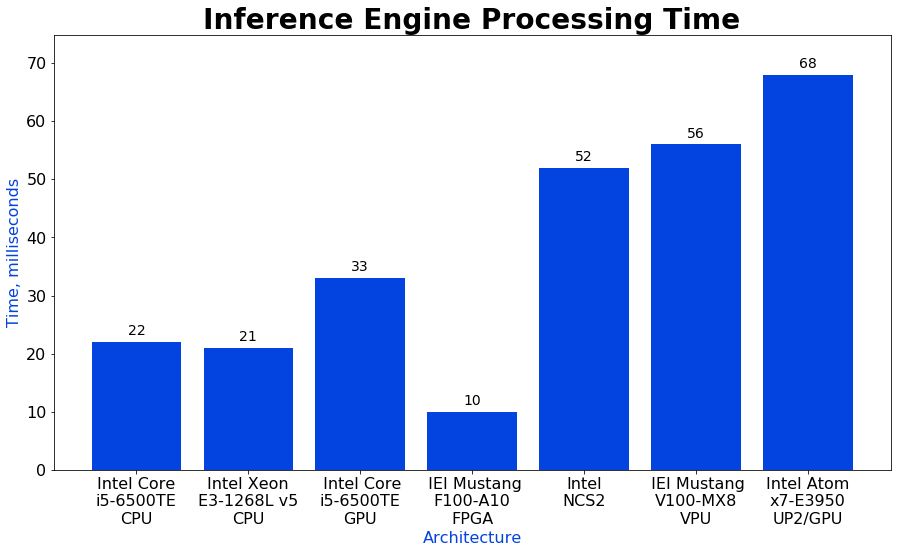

In [169]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('myriadx', 'Intel\nNCS2'),
             ('hddl', ' IEI Mustang\nV100-MX8\nVPU'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/'+arch+'/stats'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

print(stats_list)

summaryPlot(stats_list, 'Architecture', 'Time, milliseconds', 'Inference Engine Processing Time', 'time' )